<a href="https://colab.research.google.com/github/smartaces/opencite/blob/main/OPENCITE_AI_Search_Visibility_Bulk_Prompt_Runner_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

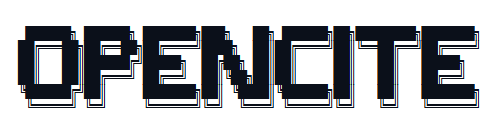

# 👋 Welcome to the OpenCite Bulk Prompt Runner!

This notebook lets you test **hundreds of prompts** against AI search models and see exactly which websites and pages get cited in the responses.

**What you can do with this tool:**
- 🔍 Run bulk searches through AI models (like OpenAI gpt 5.2 with web search)
- 📊 Track which domains and pages appear in AI-generated citations
- 🔁 Test the same prompts multiple times to measure consistency
- 💬 Simulate multi-turn conversations with custom personas
- 📈 Generate reports on citation patterns, rankings, and trends

---

**🧭 How this notebook works:**

Think of it as a recipe — run each cell in order, follow the prompts, and you'll have citation data ready to analyse. Each step has clear instructions, so you don't need to be a coder to use it.

| Step | What you'll do |
|------|----------------|
| 1 | Set up your workspace |
| 2 | Download the OpenCite scripts |
| 3 | Connect your OpenAI API key |
| 4 | Upload your prompts (CSV) |
| 5 | Run the batch |
| 6 | Browse the results |
| 7 | Analyse with reports |

---

**🔗 Connect and Learn More**

- 🌐 Project website: [OpenCite.ai](https://opencite.ai)
- ⭐ GitHub repo: [github.com/smartaces/opencite](https://github.com/smartaces/opencite)

If you find this useful, please leave a star on GitHub — it helps others discover the project!

# 📁 Step 1: Set Up Your Workspace

Before we do anything else, we need to choose where to save your project files.

**What happens when you run this cell:**
1. You'll see a dropdown to pick a storage location
2. Click **"Select Location"** to confirm
3. Then either create a new project or continue an existing one

---

**💡 Which location should I pick?**

| Option | Best for | Notes |
|--------|----------|-------|
| **Google Drive** ✅ | Most users | Your work is saved permanently and syncs across devices |
| **Colab Temporary** | Quick experiments | ⚠️ Files disappear when your session ends |
| **Local Folder** | Running outside Colab | Saves to your current directory |

---

**▶️ Ready?** Run the cell below, then follow the prompts to set up your workspace.

In [ ]:
# @title
# =============================================================================
# CELL 1: WORKSPACE SETUP
# =============================================================================
# This cell does two things:
# 1. Lets you choose where to store your project (Google Drive recommended)
# 2. Creates all the necessary subfolders including the scripts folder
#
# Run this cell first, then click "Select Base Location" and follow the prompts.
# =============================================================================

import json
import os
import sys
from datetime import datetime
from pathlib import Path

import ipywidgets as widgets
from IPython.display import clear_output, display

try:
    from google.colab import drive  # type: ignore
except ImportError:
    drive = None

IN_COLAB = "google.colab" in sys.modules


def _default_project_name() -> str:
    return f"project_{datetime.utcnow().strftime('%Y%m%d_%H%M%S')}"


def _ensure_drive_mounted() -> Path:
    if drive is None:
        raise RuntimeError("google.colab.drive is unavailable in this environment.")
    mount_point = Path("/content/drive")
    if not mount_point.exists() or not os.path.ismount(mount_point):
        print("🔌 Mounting Google Drive...")
        drive.mount(str(mount_point))
    return mount_point / "MyDrive"


def _scan_existing_projects(workspace_root: Path) -> list[tuple[str, str]]:
    """Scan workspace_root for existing project folders, sorted by most recently modified."""
    if not workspace_root.exists():
        return []

    folders = []
    try:
        for item in workspace_root.iterdir():
            if item.is_dir() and not item.name.startswith('.'):
                try:
                    mtime = item.stat().st_mtime
                    folders.append((item, mtime))
                except OSError:
                    continue
    except PermissionError:
        return []

    folders.sort(key=lambda x: x[1], reverse=True)

    result = []
    for folder_path, mtime in folders:
        modified_date = datetime.fromtimestamp(mtime).strftime('%Y-%m-%d %H:%M')
        label = f"{folder_path.name}  (modified: {modified_date})"
        result.append((label, str(folder_path)))

    return result


def _build_location_options():
    if IN_COLAB:
        return [
            ("Google Drive Folder (/content/drive/MyDrive)", "drive"),
            ("Google Colab Temporary Folder (/content)", "colab"),
            ("Local Folder (current directory)", "local"),
        ]
    else:
        return [
            ("Local Folder (current directory)", "local"),
        ]


def _create_workspace_structure(workspace_path: Path) -> dict:
    """Create all workspace subfolders and return PATHS dict."""
    subfolders = {
        "scripts": workspace_path / "scripts",
        "search_results": workspace_path / "search_results",
        "extracted_raw": workspace_path / "extracted_raw",
        "csv_output": workspace_path / "csv_output",
        "grabbed": workspace_path / "grabbed",
        "terms_lists": workspace_path / "terms_lists",
        "logs": workspace_path / "logs",
    }

    for path in subfolders.values():
        path.mkdir(parents=True, exist_ok=True)

    return {name: str(path) for name, path in subfolders.items()}


def _write_workspace_config(workspace_path: Path, paths: dict) -> Path:
    """Write workspace config file and return its path."""
    config = {
        "workspace_root": str(workspace_path),
        "paths": paths,
    }
    config_path = workspace_path / "workspace_config.json"
    with open(config_path, "w", encoding="utf-8") as fp:
        json.dump(config, fp, indent=2)
    return config_path


def _setup_smart_file_handling(workspace_path: Path):
    """Override builtins.open to resolve relative paths to workspace."""
    import builtins
    _original_open = builtins.open

    def smart_open(file, *args, **kwargs):
        file_path = Path(file)
        if not file_path.is_absolute():
            file_path = workspace_path / file_path
        file_path.parent.mkdir(parents=True, exist_ok=True)
        return _original_open(file_path, *args, **kwargs)

    builtins.open = smart_open


def configure_workspace(default_folder: str = "opencite_workspace") -> None:
    state: dict[str, Path | None] = {"base_path": None}

    header = widgets.HTML("<h3>📁 Workspace Setup</h3>")

    location_dropdown = widgets.Dropdown(
        options=_build_location_options(),
        value=_build_location_options()[0][1],
        description="Location:",
        style={'description_width': '80px'},
        layout=widgets.Layout(width="450px"),
    )
    select_base_button = widgets.Button(
        description="Select Location",
        icon="map",
        button_style="info",
        layout=widgets.Layout(width="140px"),
    )
    base_status_output = widgets.Output()

    stage_container = widgets.VBox(
        [
            header,
            widgets.HTML("<p>Choose where to store your project. Google Drive is recommended for persistence.</p>"),
            widgets.HBox([location_dropdown, select_base_button], layout=widgets.Layout(gap='8px')),
            base_status_output,
        ],
        layout=widgets.Layout(width="100%", gap="8px"),
    )

    def _render_folder_stage(base_path: Path):
        workspace_root = (base_path / default_folder).expanduser().resolve()
        workspace_root.mkdir(parents=True, exist_ok=True)

        existing_projects = _scan_existing_projects(workspace_root)
        has_existing = len(existing_projects) > 0

        mode_state = {"mode": "existing" if has_existing else "new"}

        # Existing project widgets
        existing_dropdown = widgets.Dropdown(
            options=[("-- Select a project --", "")] + existing_projects,
            value="",
            style={'description_width': '100px'},
            layout=widgets.Layout(width="500px"),
        )
        switch_to_new_button = widgets.Button(
            description="Create new project instead",
            button_style="",
            icon="plus",
            layout=widgets.Layout(width="220px"),
        )
        existing_section = widgets.VBox([
            widgets.HTML(f"<b>Continue an existing project</b> ({len(existing_projects)} found)"),
            existing_dropdown,
            switch_to_new_button,
        ])

        # New project widgets
        project_name_input = widgets.Text(
            value=_default_project_name(),
            placeholder="project_YYYYMMDD_HHMMSS",
            style={'description_width': '100px'},
            layout=widgets.Layout(width="450px"),
        )
        switch_to_existing_button = widgets.Button(
            description="Select existing project instead",
            button_style="",
            icon="folder-open",
            layout=widgets.Layout(width="240px"),
        )
        new_section = widgets.VBox([
            widgets.HTML("<b>Create a new project</b>"),
            project_name_input,
            switch_to_existing_button if has_existing else widgets.HTML(""),
        ])

        base_path_label = widgets.HTML(f"<b>Workspace location:</b> {workspace_root}")

        action_button = widgets.Button(
            description="Open Project" if has_existing else "Create Project",
            button_style="primary",
            icon="folder-open" if has_existing else "plus",
            layout=widgets.Layout(width="150px"),
        )
        status_output = widgets.Output()

        mode_container = widgets.VBox([existing_section if has_existing else new_section])

        def _switch_to_new(_):
            mode_state["mode"] = "new"
            mode_container.children = [new_section]
            action_button.description = "Create Project"
            action_button.icon = "plus"
            existing_dropdown.value = ""

        def _switch_to_existing(_):
            mode_state["mode"] = "existing"
            mode_container.children = [existing_section]
            action_button.description = "Open Project"
            action_button.icon = "folder-open"

        def _handle_action(_):
            with status_output:
                clear_output()
                try:
                    if mode_state["mode"] == "existing":
                        selected = existing_dropdown.value
                        if not selected:
                            raise RuntimeError("Select a project from the dropdown.")
                        workspace_path = Path(selected).expanduser().resolve()
                    else:
                        project_name = project_name_input.value.strip()
                        if not project_name:
                            raise RuntimeError("Enter a project folder name.")
                        workspace_path = (workspace_root / project_name).expanduser().resolve()

                    # Create workspace structure
                    paths = _create_workspace_structure(workspace_path)

                    # Write config
                    config_path = _write_workspace_config(workspace_path, paths)

                    # Set up environment
                    os.environ["WORKSPACE_ROOT"] = str(workspace_path)
                    os.environ["WORKSPACE_CONFIG"] = str(config_path)

                    # Set globals
                    import __main__
                    __main__.WORKSPACE_ROOT = workspace_path
                    __main__.PATHS = {k: Path(v) for k, v in paths.items()}
                    __main__.WORKSPACE_CONFIG = config_path

                    # Also set in current namespace
                    globals()["WORKSPACE_ROOT"] = workspace_path
                    globals()["PATHS"] = {k: Path(v) for k, v in paths.items()}
                    globals()["WORKSPACE_CONFIG"] = config_path

                    # Setup smart file handling
                    _setup_smart_file_handling(workspace_path)

                    print(f"✅ Workspace ready: {workspace_path}")
                    print(f"📂 Folders created:")
                    for name in paths:
                        print(f"   • {name}")
                    print(f"\n➡️ Run the next cell to download/update scripts.")

                except Exception as exc:
                    print(f"❌ {exc}")

        switch_to_new_button.on_click(_switch_to_new)
        switch_to_existing_button.on_click(_switch_to_existing)
        action_button.on_click(_handle_action)

        stage_container.children = [
            header,
            widgets.HTML("<p><strong>Location selected.</strong> Now choose or create a project.</p>"),
            base_path_label,
            widgets.HTML("<hr style='margin: 12px 0;'>"),
            mode_container,
            widgets.HTML("<hr style='margin: 12px 0;'>"),
            action_button,
            status_output,
        ]

    def _handle_base_select(_):
        with base_status_output:
            clear_output()
            try:
                selection = location_dropdown.value
                if selection == "colab":
                    base_path = Path("/content")
                elif selection == "drive":
                    base_path = _ensure_drive_mounted()
                elif selection == "local":
                    base_path = Path.cwd()
                else:
                    base_path = Path.cwd()

                base_path = base_path.expanduser().resolve()
                if not base_path.exists():
                    base_path.mkdir(parents=True, exist_ok=True)
                state["base_path"] = base_path
                print(f"📍 Location ready: {base_path}")
                _render_folder_stage(base_path)
            except Exception as exc:
                state["base_path"] = None
                print(f"❌ {exc}")

    select_base_button.on_click(_handle_base_select)

    display(stage_container)


# Run the workspace configuration UI
configure_workspace()

# 📦 Step 2: Download the OpenCite Scripts

This cell fetches the latest OpenCite tools from GitHub and saves them to your workspace.

**What happens when you run this cell:**
- **First time?** Scripts download automatically — just wait for the ✅ confirmation
- **Already have scripts?** You'll see version info and can check for updates

---

**🔄 Button guide:**

| Button | What it does |
|--------|--------------|
| **Check for Updates** | Compares your version to the latest on GitHub |
| **Force Update** | Re-downloads all scripts (use if something seems broken) |

---

**▶️ Run the cell below.** Once you see "Scripts ready", move on to the next step.

In [ ]:
# @title
# =============================================================================
# CELL 2: DOWNLOAD/UPDATE SCRIPTS
# =============================================================================
# This cell downloads the OpenCite scripts from GitHub and keeps them updated.
# - First run: Downloads all scripts to your workspace/scripts folder
# - Subsequent runs: Shows version info with update options
#
# Scripts are stored locally so you can work offline after the first download.
# =============================================================================

import json
import os
import urllib.request
import urllib.error
from datetime import datetime
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

# GitHub repository settings
GITHUB_REPO = "smartaces/opencite"
GITHUB_BRANCH = "main"
GITHUB_FOLDER = "bulk_loader"
GITHUB_API_BASE = f"https://api.github.com/repos/{GITHUB_REPO}"
GITHUB_RAW_BASE = f"https://raw.githubusercontent.com/{GITHUB_REPO}/{GITHUB_BRANCH}/{GITHUB_FOLDER}"

# Expected script files (in order)
SCRIPT_FILES = [
    "cell_00_pip_installs.py",
    "cell_01_folders_setup.py",
    "cell_02_api_key.py",
    "cell_03_report_helper.py",
    "cell_04_search_agent.py",
    "cell_05_csv_loader.py",
    "cell_06_batch_runner.py",
    "cell_07_results_viewer.py",
    "cell_08_dataset_builder.py",
    "cell_09_domain_report.py",
    "cell_10_page_report.py",
    "cell_11_prompt_report.py",
]

VERSION_FILE = "version_info.txt"


def _get_scripts_dir() -> Path:
    """Get the scripts directory from PATHS or environment."""
    if 'PATHS' in globals() and 'scripts' in globals()['PATHS']:
        return Path(globals()['PATHS']['scripts'])

    # Try from __main__
    import __main__
    if hasattr(__main__, 'PATHS') and 'scripts' in __main__.PATHS:
        return Path(__main__.PATHS['scripts'])

    # Fallback to environment
    config_path = os.environ.get("WORKSPACE_CONFIG")
    if config_path and Path(config_path).is_file():
        with open(config_path, "r", encoding="utf-8") as fp:
            data = json.load(fp)
        return Path(data["paths"]["scripts"])

    raise RuntimeError("Workspace not configured. Run Cell 1 first.")


def _read_version_info(scripts_dir: Path) -> dict | None:
    """Read local version info if it exists."""
    version_path = scripts_dir / VERSION_FILE
    if not version_path.is_file():
        return None
    try:
        with open(version_path, "r", encoding="utf-8") as fp:
            return json.load(fp)
    except (json.JSONDecodeError, IOError):
        return None


def _write_version_info(scripts_dir: Path, commit_sha: str, commit_date: str) -> None:
    """Write version info to local file."""
    version_path = scripts_dir / VERSION_FILE
    data = {
        "commit_sha": commit_sha,
        "commit_date": commit_date,
        "downloaded_at": datetime.utcnow().isoformat() + "Z",
    }
    with open(version_path, "w", encoding="utf-8") as fp:
        json.dump(data, fp, indent=2)


def _fetch_latest_commit() -> dict | None:
    """Fetch latest commit info from GitHub API."""
    url = f"{GITHUB_API_BASE}/commits/{GITHUB_BRANCH}"
    try:
        req = urllib.request.Request(url, headers={"User-Agent": "OpenCite-Updater"})
        with urllib.request.urlopen(req, timeout=10) as response:
            data = json.loads(response.read().decode("utf-8"))
            return {
                "sha": data["sha"][:7],
                "date": data["commit"]["committer"]["date"],
                "message": data["commit"]["message"].split("\n")[0][:50],
            }
    except (urllib.error.URLError, urllib.error.HTTPError, KeyError, json.JSONDecodeError):
        return None


def _download_file(filename: str, scripts_dir: Path) -> bool:
    """Download a single file from GitHub."""
    url = f"{GITHUB_RAW_BASE}/{filename}"
    dest = scripts_dir / filename
    try:
        req = urllib.request.Request(url, headers={"User-Agent": "OpenCite-Updater"})
        with urllib.request.urlopen(req, timeout=30) as response:
            content = response.read()
        with open(dest, "wb") as fp:
            fp.write(content)
        return True
    except (urllib.error.URLError, urllib.error.HTTPError, IOError):
        return False


def _download_all_scripts(scripts_dir: Path, output: widgets.Output) -> bool:
    """Download all scripts from GitHub."""
    with output:
        print("📥 Downloading scripts from GitHub...")

        success_count = 0
        for filename in SCRIPT_FILES:
            print(f"   • {filename}...", end=" ")
            if _download_file(filename, scripts_dir):
                print("✓")
                success_count += 1
            else:
                print("✗ FAILED")

        if success_count == len(SCRIPT_FILES):
            # Get commit info and save version
            commit_info = _fetch_latest_commit()
            if commit_info:
                _write_version_info(scripts_dir, commit_info["sha"], commit_info["date"])
                print(f"\n✅ All {success_count} scripts downloaded (version: {commit_info['sha']})")
            else:
                _write_version_info(scripts_dir, "unknown", datetime.utcnow().isoformat())
                print(f"\n✅ All {success_count} scripts downloaded")
            return True
        else:
            print(f"\n⚠️ Downloaded {success_count}/{len(SCRIPT_FILES)} scripts")
            return False


def _count_existing_scripts(scripts_dir: Path) -> int:
    """Count how many expected scripts exist locally."""
    return sum(1 for f in SCRIPT_FILES if (scripts_dir / f).is_file())


def setup_scripts_ui() -> None:
    """Display the scripts download/update UI."""
    try:
        scripts_dir = _get_scripts_dir()
    except RuntimeError as e:
        print(f"❌ {e}")
        return

    scripts_dir.mkdir(parents=True, exist_ok=True)

    # Check current state
    existing_count = _count_existing_scripts(scripts_dir)
    version_info = _read_version_info(scripts_dir)
    is_first_run = existing_count == 0

    # UI elements
    header = widgets.HTML("<h3>📦 Script Manager</h3>")
    status_output = widgets.Output()
    action_output = widgets.Output()

    check_button = widgets.Button(
        description="Check for Updates",
        icon="refresh",
        button_style="info",
        layout=widgets.Layout(width="160px"),
    )
    force_button = widgets.Button(
        description="Force Update",
        icon="download",
        button_style="warning",
        layout=widgets.Layout(width="140px"),
    )
    button_row = widgets.HBox([check_button, force_button], layout=widgets.Layout(gap="8px"))

    def _show_status():
        with status_output:
            clear_output()
            if is_first_run:
                print("📭 No scripts found. Click 'Force Update' to download.")
            elif version_info:
                downloaded = version_info.get("downloaded_at", "unknown")
                if downloaded != "unknown":
                    try:
                        dt = datetime.fromisoformat(downloaded.replace("Z", "+00:00"))
                        downloaded = dt.strftime("%Y-%m-%d %H:%M UTC")
                    except ValueError:
                        pass
                print(f"📦 Scripts installed: {existing_count}/{len(SCRIPT_FILES)} files")
                print(f"   Version: {version_info.get('commit_sha', 'unknown')}")
                print(f"   Downloaded: {downloaded}")
            else:
                print(f"📦 Scripts found: {existing_count}/{len(SCRIPT_FILES)} files")
                print("   Version: unknown (no version_info.txt)")

    def _handle_check(_):
        with action_output:
            clear_output()
            print("🔍 Checking for updates...")

            latest = _fetch_latest_commit()
            if latest is None:
                print("⚠️ Couldn't connect to GitHub. You can work offline with cached scripts.")
                return

            local_sha = version_info.get("commit_sha") if version_info else None

            if local_sha == latest["sha"]:
                print(f"✅ You're up to date! (version: {latest['sha']})")
            else:
                print(f"🆕 Update available!")
                print(f"   Your version: {local_sha or 'unknown'}")
                print(f"   Latest version: {latest['sha']}")
                print(f"   Latest commit: {latest['message']}")
                print(f"\n   Click 'Force Update' to download the latest version.")

    def _handle_force(_):
        with action_output:
            clear_output()
            if _download_all_scripts(scripts_dir, action_output):
                print(f"\n➡️ Scripts ready at: {scripts_dir}")
                print("   Run the next cell to continue.")
                # Refresh status
                nonlocal version_info, existing_count, is_first_run
                version_info = _read_version_info(scripts_dir)
                existing_count = _count_existing_scripts(scripts_dir)
                is_first_run = False
                _show_status()

    check_button.on_click(_handle_check)
    force_button.on_click(_handle_force)

    # Show initial status
    _show_status()

    # Auto-download on first run
    if is_first_run:
        with action_output:
            clear_output()
            if _download_all_scripts(scripts_dir, action_output):
                print(f"\n➡️ Scripts ready at: {scripts_dir}")
                print("   Run the next cell to continue.")
                # Refresh status
                version_info = _read_version_info(scripts_dir)
                existing_count = _count_existing_scripts(scripts_dir)
                _show_status()

    # Display UI
    container = widgets.VBox([
        header,
        widgets.HTML("<p>Existing tool scripts identified, you can proceed with these.</p> <p>Alternatively click 'Check for Updates' to check for newer versions if you like, or click 'Force Update' to install any potential updates.</p>"),
        status_output,
        widgets.HTML("<hr style='margin: 12px 0;'>"),
        button_row,
        action_output,
    ])

    display(container)


# Run the UI
setup_scripts_ui()

# 🔧 Step 3: Connect to OpenAI

This cell installs dependencies, loads your API key, and sets up the AI search agent.

**What happens when you run this cell:**
1. Installs required Python packages (silent, takes a few seconds)
2. Loads your OpenAI API key
3. Shows a model selector dropdown

---

**🔑 First time? You'll need to add your OpenAI API key:**

<details>
<summary><b>In Google Colab (click to expand)</b></summary>

1. Click the 🔑 **key icon** in the left sidebar (Secrets)
2. Click **"+ Add new secret"**
3. Name: `openai_key`
4. Value: your OpenAI API key (starts with `sk-...`)
5. Toggle **"Notebook access"** ON
6. Re-run this cell

</details>

<details>
<summary><b>Running locally (click to expand)</b></summary>

1. Create a `.env` file in your project folder
2. Add: `OPENAI_API_KEY=sk-your-key-here`
3. Re-run this cell

</details>

🔗 Need an API key? Get one at [platform.openai.com/api-keys](https://platform.openai.com/api-keys)

---

**🤖 Model selection:**

Once your API key is configured, you'll see a dropdown to choose your AI model. The default (`gpt-5.2`) works great for most use cases — just click **"Confirm Model"** to continue. You can also update this to expand the OpenAI model option by modifying the source code in the repo if you want.

https://github.com/smartaces/opencite/tree/main/bulk_loader

---

**▶️ Run the cell below.** If you see "Search agent ready", you're good to go!

In [ ]:
# @title
# =============================================================================
# CELL 3: LOAD CORE SCRIPTS & SETUP
# =============================================================================
# This cell loads all the foundational scripts and displays the model selector.
#
# It runs:
# - Pip installs (silent)
# - API key configuration
# - ReportHelper class
# - Dataset builder
# - Search agent with model selector UI
#
# After running, you'll see the model dropdown to select your preferred model.
# =============================================================================

import os
import time
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

# Get scripts directory
def _get_scripts_path() -> Path:
    """Get the scripts directory path."""
    if 'PATHS' in globals() and 'scripts' in globals()['PATHS']:
        return Path(globals()['PATHS']['scripts'])

    import __main__
    if hasattr(__main__, 'PATHS') and 'scripts' in __main__.PATHS:
        return Path(__main__.PATHS['scripts'])

    config_path = os.environ.get("WORKSPACE_CONFIG")
    if config_path and Path(config_path).is_file():
        import json
        with open(config_path, "r", encoding="utf-8") as fp:
            data = json.load(fp)
        return Path(data["paths"]["scripts"])

    raise RuntimeError("Workspace not configured. Run Cell 1 first.")


scripts_dir = _get_scripts_path()

if not scripts_dir.exists():
    raise RuntimeError(f"Scripts folder not found: {scripts_dir}\nRun Cell 2 to download scripts.")

# Create output widget for setup messages
setup_output = widgets.Output()
display(setup_output)

api_key_error = None

with setup_output:
    print("🔧 Loading core scripts...\n")

    # 1. Pip installs
    print("   Installing dependencies...", end=" ", flush=True)
    import subprocess
    import sys
    try:
        subprocess.check_call(
            [sys.executable, "-m", "pip", "install", "--quiet",
             "openai", "rich", "python-dotenv", "ipywidgets", "plotly"],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
        )
        print("✓")
    except subprocess.CalledProcessError:
        print("⚠️")

    # 2. API key configuration
    print("   Configuring API key...", end=" ", flush=True)
    api_script = scripts_dir / "cell_02_api_key.py"
    if api_script.exists():
        try:
            # Suppress the script's own print statements temporarily
            import io
            import sys as _sys
            _old_stdout = _sys.stdout
            _sys.stdout = io.StringIO()
            try:
                exec(compile(open(api_script).read(), api_script, 'exec'))
            finally:
                _sys.stdout = _old_stdout
            print("✓")
        except RuntimeError as e:
            _sys.stdout = _old_stdout
            print("✗")
            api_key_error = e
    else:
        raise RuntimeError(f"Required script not found: {api_script}")

    # 3. ReportHelper class
    print("   Loading ReportHelper...", end=" ", flush=True)
    report_script = scripts_dir / "cell_03_report_helper.py"
    if report_script.exists():
        exec(compile(open(report_script).read(), report_script, 'exec'))
        print("✓")
    else:
        raise RuntimeError(f"Required script not found: {report_script}")

    # 4. Dataset builder & filter helpers
    print("   Loading dataset builder...", end=" ", flush=True)
    dataset_script = scripts_dir / "cell_08_dataset_builder.py"
    if dataset_script.exists():
        # Capture and suppress the script's confirmation message
        import io
        import sys as _sys
        _old_stdout = _sys.stdout
        _sys.stdout = io.StringIO()
        try:
            exec(compile(open(dataset_script).read(), dataset_script, 'exec'))
        finally:
            _sys.stdout = _old_stdout
        print("✓")
    else:
        print("⚠️")

    print("\n✅ Core scripts loaded.")

# Handle API key error with helpful message
if api_key_error:
    with setup_output:
        print("\n" + "=" * 60)
        print("❌ API KEY NOT CONFIGURED")
        print("=" * 60)
        print("\nOpenAI API key is required to use the search agent.\n")
        print("📋 SETUP INSTRUCTIONS:")
        print("\n🔹 In Google Colab:")
        print("   1. Click the 🔑 key icon in the left sidebar (Secrets)")
        print("   2. Click '+ Add new secret'")
        print("   3. Name: openai_key")
        print("   4. Value: your OpenAI API key (starts with sk-...)")
        print("   5. Toggle 'Notebook access' ON")
        print("   6. Re-run this cell")
        print("\n🔹 Running locally:")
        print("   1. Create a .env file in your project folder")
        print("   2. Add: OPENAI_API_KEY=sk-your-key-here")
        print("   3. Re-run this cell")
        print("\n🔗 Get an API key at: https://platform.openai.com/api-keys")
        print("=" * 60)
    raise RuntimeError("API key setup required. Follow the instructions above.")

# Brief pause so user sees the success message
time.sleep(0.5)

# Clear setup output and show only the Search Agent UI
setup_output.clear_output()

with setup_output:
    print("✅ Core scripts loaded successfully.\n")

# Load search agent with model selector UI
agent_script = scripts_dir / "cell_04_search_agent.py"
if agent_script.exists():
    exec(compile(open(agent_script).read(), agent_script, 'exec'))
else:
    raise RuntimeError(f"Required script not found: {agent_script}")

Output()

🤖 gpt-5.2 initialized (default)
✅ format_location helper ready
ℹ️ Use the dropdown above to change models if needed


# 📄 Step 4: Upload Your Prompts

This cell lets you upload a CSV file containing the prompts you want to test, map the columns, and save a normalized file.

**What happens when you run this cell:**
1. Upload your CSV file (or use one of our templates below)
2. The tool auto-detects your columns where possible
3. Map any remaining columns manually
4. Click **"Save Settings"** to create your normalized prompt file

---

**📥 Template files to get you started:**

| Template | Description | Link |
|----------|-------------|------|
| **Simple (single-turn)** | Basic prompts with 1 turn per query | [Download template](https://docs.google.com/spreadsheets/d/1ESdT4CPKNdG98-bt087LhsBcqP5_SGAugO7mOcCEgug/edit?usp=sharing) |
| **Multi-turn with personas** | Simulates deeper conversations with user personas | [Download template](https://docs.google.com/spreadsheets/d/1otLDMxD_F3Rx44rvvpGkv1Dwd_pjw7EJIuRHikgcIM8/edit?usp=sharing) |

> 💡 **Tip:** Open a template, go to **File → Download → CSV**, then upload it here.

---

**📋 Column guide:**

| Column | Required? | What it does |
|--------|-----------|--------------|
| **Prompt** | ✅ Yes | The search query or question to test |
| **Persona** | Optional | User context (e.g. "£500 budget shopper, likes Android") |
| **Runs** | Optional | How many times to repeat each prompt (default: 1) |
| **Turns** | Optional | Conversation depth — 1 = single query, 2+ = follow-up questions |

---

**▶️ Run the cell below**, upload your CSV, check the column mappings, then click **"Save Settings"**.

In [ ]:
# @title
# =============================================================================
# CELL 4: CSV LOADER
# =============================================================================
# This cell loads the CSV/prompt loader interface.
# Upload or select a CSV file with your prompts to run through the search agent.
# =============================================================================

import os
from pathlib import Path

# Get scripts directory
def _get_scripts_path() -> Path:
    """Get the scripts directory path."""
    if 'PATHS' in globals() and 'scripts' in globals()['PATHS']:
        return Path(globals()['PATHS']['scripts'])

    import __main__
    if hasattr(__main__, 'PATHS') and 'scripts' in __main__.PATHS:
        return Path(__main__.PATHS['scripts'])

    config_path = os.environ.get("WORKSPACE_CONFIG")
    if config_path and Path(config_path).is_file():
        import json
        with open(config_path, "r", encoding="utf-8") as fp:
            data = json.load(fp)
        return Path(data["paths"]["scripts"])

    raise RuntimeError("Workspace not configured. Run Cell 1 first.")


scripts_dir = _get_scripts_path()
csv_loader_script = scripts_dir / "cell_05_csv_loader.py"

if not csv_loader_script.exists():
    raise RuntimeError(f"Script not found: {csv_loader_script}\nRun Cell 2 to download scripts.")

# Run the CSV loader UI
exec(compile(open(csv_loader_script).read(), csv_loader_script, 'exec'))

# 🚀 Step 5: Run Your Prompts

This is where the magic happens! This cell sends your prompts to the AI search agent and records all the responses and citations.

**What happens when you run this cell:**
1. Select your prompt file from the dropdown
2. Configure your run settings (optional)
3. Click **"Run Batch"** and watch the results come in

---

**⚙️ Settings explained:**

| Setting | What it does | Recommendation |
|---------|--------------|----------------|
| **Run label** | Tags your output files for easy identification | Add a short name like "phones_uk_test" |
| **Search depth** | How much web content the AI retrieves | Medium works well for most cases |
| **Reasoning effort** | How deeply the AI analyses before responding | Low is faster; High gives more nuanced answers |
| **Parallel runs** | Run multiple queries simultaneously | 3 is a good balance of speed and stability |
| **Location bias** | Personalises results as if searching from a specific location | Enable if location matters for your queries |

---

**⏱️ How long does it take?**

Depends on your prompt count, runs, and turns. A batch of 10 prompts with 2 runs and 1 turn typically takes 2–5 minutes.

You'll see a progress spinner and summary as each prompt completes.

---

**▶️ Run the cell below**, select your CSV file, configure settings if needed, then click **"Run Batch"**.

In [ ]:
# @title
# =============================================================================
# CELL 5: BATCH RUNNER
# =============================================================================
# This cell loads the batch runner interface.
# Select a CSV file and configure settings to run prompts through the search agent.
# =============================================================================

import os
from pathlib import Path

# Get scripts directory
def _get_scripts_path() -> Path:
    """Get the scripts directory path."""
    if 'PATHS' in globals() and 'scripts' in globals()['PATHS']:
        return Path(globals()['PATHS']['scripts'])

    import __main__
    if hasattr(__main__, 'PATHS') and 'scripts' in __main__.PATHS:
        return Path(__main__.PATHS['scripts'])

    config_path = os.environ.get("WORKSPACE_CONFIG")
    if config_path and Path(config_path).is_file():
        import json
        with open(config_path, "r", encoding="utf-8") as fp:
            data = json.load(fp)
        return Path(data["paths"]["scripts"])

    raise RuntimeError("Workspace not configured. Run Cell 1 first.")


scripts_dir = _get_scripts_path()
batch_runner_script = scripts_dir / "cell_06_batch_runner.py"

if not batch_runner_script.exists():
    raise RuntimeError(f"Script not found: {batch_runner_script}\nRun Cell 2 to download scripts.")

# Run the batch runner UI
exec(compile(open(batch_runner_script).read(), batch_runner_script, 'exec'))

# 📊 Step 7: Analyse Your Citations

This is where you turn raw data into insights. Explore which domains and pages the AI cites most, and how your prompts perform.

**What happens when you run this cell:**
1. Select a report type from the dropdown
2. Click **"Load Report"** to view it
3. Use filters to slice the data, then export what you need

---

**📈 Available reports:**

| Report | What it shows |
|--------|---------------|
| **Domain Report** | Aggregate stats by domain — which sites get cited most, average rank, citation share |
| **Page Report** | Individual URL performance — see exactly which pages appear in AI responses |
| **Prompt Report** | Prompt-level insights — which queries generate the most citations, and from where |

---

**🎛️ Common controls:**

| Button | What it does |
|--------|--------------|
| **Refresh data** | Reload with any new batch results |
| **Force rebuild** | Rebuild the entire dataset from scratch |
| **Export All** | Download the full report as CSV |
| **Export View** | Download only the currently filtered view |
| **Export highlights** | Download top performers (impact, velocity, authority) |

---

**💡 Tips:**
- Use the **Column picker** to show/hide metrics
- Sort by **Overall Impact Score** to find the most significant sources
- Filter by **Run label** to compare different batches

---

**▶️ Run the cell below**, choose a report type, and start exploring your citation data!

In [ ]:
# @title
# =============================================================================
# CELL 7: REPORTS
# =============================================================================
# This cell provides access to all report types via a dropdown selector.
# Switch between Domain, Page, and Prompt reports without running separate cells.
# =============================================================================

import os
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

# Get scripts directory
def _get_scripts_path() -> Path:
    """Get the scripts directory path."""
    if 'PATHS' in globals() and 'scripts' in globals()['PATHS']:
        return Path(globals()['PATHS']['scripts'])

    import __main__
    if hasattr(__main__, 'PATHS') and 'scripts' in __main__.PATHS:
        return Path(__main__.PATHS['scripts'])

    config_path = os.environ.get("WORKSPACE_CONFIG")
    if config_path and Path(config_path).is_file():
        import json
        with open(config_path, "r", encoding="utf-8") as fp:
            data = json.load(fp)
        return Path(data["paths"]["scripts"])

    raise RuntimeError("Workspace not configured. Run Cell 1 first.")


scripts_dir = _get_scripts_path()

# Report options
REPORTS = {
    "domain": {
        "label": "Domain Report – Aggregate citations by domain",
        "script": "cell_09_domain_report.py",
    },
    "page": {
        "label": "Page Report – Individual URL citations",
        "script": "cell_10_page_report.py",
    },
    "prompt": {
        "label": "Prompt Report – Citations by prompt/query",
        "script": "cell_11_prompt_report.py",
    },
}

# UI Elements
header = widgets.HTML("<h3>📊 Reports</h3>")

report_dropdown = widgets.Dropdown(
    options=[(v["label"], k) for k, v in REPORTS.items()],
    value="domain",
    description="Report:",
    style={'description_width': '60px'},
    layout=widgets.Layout(width="450px"),
)

load_button = widgets.Button(
    description="Load Report",
    icon="bar-chart",
    button_style="primary",
    layout=widgets.Layout(width="130px"),
)

refresh_button = widgets.Button(
    description="Refresh",
    icon="refresh",
    button_style="info",
    layout=widgets.Layout(width="100px"),
)

report_output = widgets.Output()

# Track current report for refresh
_current_report = {"key": None}


def _load_report(report_key: str):
    """Load and display the selected report."""
    report_info = REPORTS.get(report_key)
    if not report_info:
        with report_output:
            clear_output()
            print(f"❌ Unknown report: {report_key}")
        return

    script_path = scripts_dir / report_info["script"]
    if not script_path.exists():
        with report_output:
            clear_output()
            print(f"❌ Script not found: {script_path}")
            print("Run Cell 2 to download scripts.")
        return

    _current_report["key"] = report_key

    with report_output:
        clear_output()
        print(f"📊 Loading {report_key.title()} Report...")
        print()
        try:
            # Execute the report script
            exec(compile(open(script_path).read(), script_path, 'exec'), globals())
        except Exception as e:
            print(f"❌ Error loading report: {e}")


def _handle_load(_):
    """Handle load button click."""
    _load_report(report_dropdown.value)


def _handle_refresh(_):
    """Handle refresh button click."""
    if _current_report["key"]:
        _load_report(_current_report["key"])
    else:
        _load_report(report_dropdown.value)


load_button.on_click(_handle_load)
refresh_button.on_click(_handle_refresh)

# Layout
controls = widgets.VBox([
    header,
    widgets.HTML("<p>Select a report type and click Load to view. Use Refresh to update with latest data.</p>"),
    widgets.HBox([report_dropdown, load_button, refresh_button], layout=widgets.Layout(gap="8px")),
    widgets.HTML("<hr style='margin: 12px 0;'>"),
    report_output,
])

display(controls)

# 🔍 Step 7: Browse Your Results By Prompt

This cell lets you explore the raw outputs from your batch runs — see the full conversations, AI responses, and citations.

**What happens when you run this cell:**
1. Your batch results load automatically
2. Use the filters to narrow down by prompt, run label, or keywords
3. Click on any run to view the full conversation

---

**🎛️ Filter options:**

| Filter | What it does |
|--------|--------------|
| **Prompt** | Show results for a specific prompt |
| **Run label** | Filter by the tag you set in Step 5 |
| **Prompt contains** | Search for keywords in the prompt text |
| **Response contains** | Search for keywords in AI responses |

---

**👀 What you'll see:**

- **Matching Runs** — A summary table of all runs matching your filters
- **Run Details** — Click "View" on any row to see:
  - The full conversation (user queries + AI responses)
  - All citations with clickable links
  - Turn-by-turn breakdown for multi-turn conversations

---

**▶️ Run the cell below** to browse your results. Use **"Refresh Data"** if you've run more batches since loading.

Prompt and response viewer

In [ ]:
# @title
# =============================================================================
# CELL 6: RESULTS VIEWER
# =============================================================================
# This cell loads the results viewer interface.
# Browse and inspect your batch run outputs, view conversations and citations.
# =============================================================================

import os
from pathlib import Path

# Get scripts directory
def _get_scripts_path() -> Path:
    """Get the scripts directory path."""
    if 'PATHS' in globals() and 'scripts' in globals()['PATHS']:
        return Path(globals()['PATHS']['scripts'])

    import __main__
    if hasattr(__main__, 'PATHS') and 'scripts' in __main__.PATHS:
        return Path(__main__.PATHS['scripts'])

    config_path = os.environ.get("WORKSPACE_CONFIG")
    if config_path and Path(config_path).is_file():
        import json
        with open(config_path, "r", encoding="utf-8") as fp:
            data = json.load(fp)
        return Path(data["paths"]["scripts"])

    raise RuntimeError("Workspace not configured. Run Cell 1 first.")


scripts_dir = _get_scripts_path()
results_viewer_script = scripts_dir / "cell_07_results_viewer.py"

if not results_viewer_script.exists():
    raise RuntimeError(f"Script not found: {results_viewer_script}\nRun Cell 2 to download scripts.")

# Run the results viewer UI
exec(compile(open(results_viewer_script).read(), results_viewer_script, 'exec'))

/content/drive/MyDrive/opencite_workspace/project_20260116_154238_today/scripts/cell_07_results_viewer.py:139: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(group["row_timestamp"], errors="coerce").min()
/content/drive/MyDrive/opencite_workspace/project_20260116_154238_today/scripts/cell_07_results_viewer.py:139: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(group["row_timestamp"], errors="coerce").min()


/content/drive/MyDrive/opencite_workspace/project_20260116_154238_today/scripts/cell_07_results_viewer.py:139: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(group["row_timestamp"], errors="coerce").min()
/content/drive/MyDrive/opencite_workspace/project_20260116_154238_today/scripts/cell_07_results_viewer.py:139: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ts = pd.to_datetime(group["row_timestamp"], errors="coerce").min()
